## Data Preprocessing and Model Training

In [1]:
# General Libraries:
import cv2
import os
from PIL import Image
import numpy as np
from sklearn.utils import shuffle
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# Deep Learning libraries:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.applications import Xception

### Data Loading and Cleaning

In [2]:
def load_data(directory):
    images = []
    labels = []

    for label in os.listdir(directory):
        for image in os.listdir(os.path.join(directory, label)):
            img_path = os.path.join(directory, label, image)

            # Read and resize the image using Pillow
            img = Image.open(img_path)
            img_array = np.array(img)

            # Append the image array and the label to the lists
            images.append(img_array)
            labels.append(label)

    # Shuffle the arrays using sklearn.utils.shuffle
    images, labels = shuffle(images, labels, random_state=42)

    return images, labels

In [3]:
train_dir = r'C:\Users\andmpereira\OneDrive - Grupo Jerónimo Martins\Documentos\GitHub\DLNN-Group2\00 - Dataset\Training'
test_dir = r'C:\Users\andmpereira\OneDrive - Grupo Jerónimo Martins\Documentos\GitHub\DLNN-Group2\00 - Dataset\Testing'

# Load training data
train_images, train_labels = load_data(train_dir)

# Load testing data
test_images, test_labels = load_data(test_dir)

In [4]:
# Check data structure

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print("Number of Images in Train Set:", num_train_images)
print("Number of Labels in Train Set:", num_train_labels)
print("Number of Images in Test Set:", num_test_images)
print("Number of Labels in Test Set:", num_test_labels)

Number of Images in Train Set: 5712
Number of Labels in Train Set: 5712
Number of Images in Test Set: 1311
Number of Labels in Test Set: 1311


In [5]:
def remove_duplicates(images, labels):
    unique_pairs = set()
    unique_images = []
    unique_labels = []
    num_removed = 0

    for img, label in zip(images, labels):
        img_str = img.tobytes()
        pair = (img_str, label)

        # Check if the pair is unique
        if pair not in unique_pairs:
            unique_pairs.add(pair)
            unique_images.append(img)
            unique_labels.append(label)
        else:
            num_removed += 1

    print(f"Removed {num_removed} duplicate images.")
    
    return shuffle(unique_images, unique_labels, random_state=99)

In [6]:
# Remove duplicates from training data
train_images, train_labels = remove_duplicates(train_images, train_labels)

# Remove duplicates from testing data
test_images, test_labels = remove_duplicates(test_images, test_labels)

Removed 207 duplicate images.
Removed 30 duplicate images.


In [7]:
def print_class_distribution(labels, dataset_name):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    
    print(f"\nClass Distribution in {dataset_name} Dataset:")
    for class_label, count in zip(unique_classes, class_counts):
        print(f"Class {class_label}: {count} images")
    
    total_images = len(labels)
    print(f"Total number of images in {dataset_name} Dataset: {total_images}")

# Print training data class distribution
print_class_distribution(train_labels, 'Training')

# Print testing data class distribution
print_class_distribution(test_labels, 'Testing')



Class Distribution in Training Dataset:
Class glioma: 1321 images
Class meningioma: 1333 images
Class notumor: 1406 images
Class pituitary: 1445 images
Total number of images in Training Dataset: 5505

Class Distribution in Testing Dataset:
Class glioma: 299 images
Class meningioma: 301 images
Class notumor: 381 images
Class pituitary: 300 images
Total number of images in Testing Dataset: 1281


### Data Preprocessing

In [8]:
# Split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=99)


In [9]:
def preprocess_images(images, desired_size, normalize=True):
    preprocessed_images = []

    for img_array in images:
        # Convert numpy array to Pillow Image
        img = Image.fromarray(img_array)

        # Convert grayscale images to RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Resize the image
        img = img.resize(desired_size)

        # Convert the image back to a numpy array
        img_array = np.array(img)

        # Normalize pixel values to the range [0, 1]
        if normalize:
            img_array = img_array / 255.0

        preprocessed_images.append(img_array)

    return preprocessed_images

In [10]:
width = 224 
height = 224

train_images_processed = preprocess_images(train_images, desired_size=(width,height))
val_images_processed = preprocess_images(val_images, desired_size=(width,height))
test_images_processed = preprocess_images(test_images, desired_size=(width,height))

train_images_processed = np.array(train_images_processed)
val_images_processed = np.array(val_images_processed)

In [11]:

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

num_classes = len(label_encoder.classes_)

train_labels_one_hot = to_categorical(train_labels_encoded, num_classes=num_classes)
val_labels_one_hot = to_categorical(val_labels_encoded, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=num_classes)

### Data Augmentation

In [12]:
# Create an ImageDataGenerator with data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Preprocess and augment training data
train_generator = datagen.flow(np.array(train_images_processed), train_labels_one_hot, batch_size=32)
val_generator = val_datagen.flow(np.array(val_images_processed), val_labels_one_hot, batch_size=32)

### Model Architecture

In [13]:
# Define the CNN model
model = models.Sequential()

# Convolutional layer with 32 filters, 3x3 kernel, and ReLU activation
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# Max pooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional layer with 64 filters, 3x3 kernel, and ReLU activation
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Max pooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional layer with 128 filters, 3x3 kernel, and ReLU activation
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# Max pooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to convert 3D feature maps to 1D feature vectors
model.add(layers.Flatten())

# Dense layer with 128 neurons and ReLU activation
model.add(layers.Dense(128, activation='relu'))

# Output layer with 4 neurons (for 4 tumor types) and softmax activation
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [14]:
# Specify the number of training steps per epoch and validation steps
train_steps_per_epoch = len(train_generator)
val_steps_per_epoch = len(val_generator)

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,  # Adjust the number of epochs based on your needs
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch)

Epoch 1/10
138/138 [==============================] - 304s 2s/step - loss: 1.2278 - accuracy: 0.4042 - val_loss: 1.0127 - val_accuracy: 0.5386
Epoch 2/10
138/138 [==============================] - 313s 2s/step - loss: 1.0029 - accuracy: 0.5702 - val_loss: 0.8765 - val_accuracy: 0.6322
Epoch 3/10
138/138 [==============================] - 307s 2s/step - loss: 0.9153 - accuracy: 0.6183 - val_loss: 0.8399 - val_accuracy: 0.6794
Epoch 4/10
138/138 [==============================] - 325s 2s/step - loss: 0.8829 - accuracy: 0.6265 - val_loss: 0.8763 - val_accuracy: 0.6385
Epoch 5/10
138/138 [==============================] - 311s 2s/step - loss: 0.8205 - accuracy: 0.6637 - val_loss: 0.7103 - val_accuracy: 0.7094
Epoch 6/10
138/138 [==============================] - 310s 2s/step - loss: 0.7961 - accuracy: 0.6857 - val_loss: 0.6530 - val_accuracy: 0.7639
Epoch 7/10
138/138 [==============================] - 309s 2s/step - loss: 0.7685 - accuracy: 0.6975 - val_loss: 0.6417 - val_accuracy: 0.7902

In [15]:
val_metrics = model.evaluate(val_generator, steps=val_steps_per_epoch)
print("Validation Metrics:", val_metrics)

35/35 [==============================] - 20s 562ms/step - loss: 0.5658 - accuracy: 0.8020
Validation Metrics: [0.5657957792282104, 0.8019981980323792]


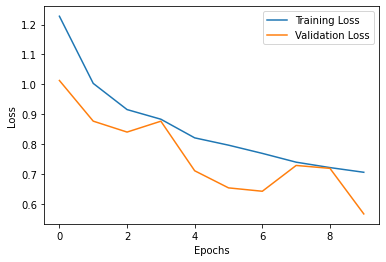

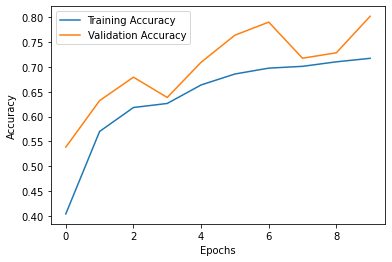

In [16]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
test_generator = val_datagen.flow(np.array(test_images_processed), test_labels_one_hot, batch_size=32)

test_steps_per_epoch = len(test_generator)
test_metrics = model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Metrics:", test_metrics)

41/41 [==============================] - 22s 534ms/step - loss: 0.7222 - accuracy: 0.7393
Test Metrics: [0.7221682667732239, 0.7392662167549133]


41/41 [==============================] - 22s 524ms/step


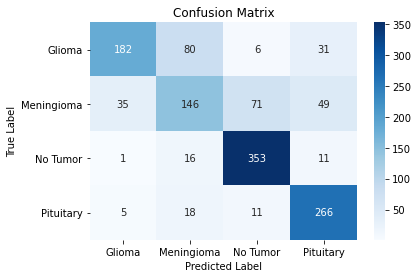

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.61      0.70       299
           1       0.56      0.49      0.52       301
           2       0.80      0.93      0.86       381
           3       0.75      0.89      0.81       300

    accuracy                           0.74      1281
   macro avg       0.73      0.73      0.72      1281
weighted avg       0.74      0.74      0.73      1281



In [18]:
# Get true labels
true_labels = []
for i in range(test_steps_per_epoch):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Get predicted labels
predicted_labels = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma','Meningioma','No Tumor','Pituitary'], yticklabels=['Glioma','Meningioma','No Tumor','Pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))



### Handling Overfitting

- Simplified the network to just 2 Conv2D with Max Pooling layers.
- Added Dropout and BatchNormalization
- Added L2 regularization
- Used Early Stopping to ensure improvement

In [19]:
# Define the CNN model
new_model = Sequential()

# Convolutional layer with 32 filters, 3x3 kernel, and ReLU activation
new_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# Max pooling layer_
new_model.add(MaxPooling2D((2, 2)))
new_model.add(BatchNormalization())

# Convolutional layer with 64 filters, 3x3 kernel, and ReLU activation
new_model.add(Conv2D(64, (3, 3), activation='relu'))
# Max pooling layer
new_model.add(MaxPooling2D((2, 2)))
new_model.add(BatchNormalization())
new_model.add(Dropout(0.2))

# Flatten layer to convert 3D feature maps to 1D feature vectors
new_model.add(Flatten())

# Dense layer with 128 neurons, ReLU activation, L2 regularization, and Batch Normalization
new_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
new_model.add(BatchNormalization())
new_model.add(Dropout(0.4))

# Output layer with 4 neurons (for 4 tumor types) and softmax activation
new_model.add(Dense(4, activation='softmax'))

# Compile the model with a lower learning rate
new_model.compile(RMSprop(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the updated model summary
new_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 111, 111, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                      

In [20]:
# Compile the new model
new_model.compile(RMSprop(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the new model with early stopping
new_history = new_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping]
)

Epoch 1/10
138/138 [==============================] - 290s 2s/step - loss: 3.7821 - accuracy: 0.5475 - val_loss: 3.8621 - val_accuracy: 0.3134
Epoch 2/10
138/138 [==============================] - 285s 2s/step - loss: 3.5914 - accuracy: 0.5876 - val_loss: 3.8158 - val_accuracy: 0.4360
Epoch 3/10
138/138 [==============================] - 301s 2s/step - loss: 3.4925 - accuracy: 0.6158 - val_loss: 3.5763 - val_accuracy: 0.4832
Epoch 4/10
138/138 [==============================] - 303s 2s/step - loss: 3.4294 - accuracy: 0.6219 - val_loss: 3.3136 - val_accuracy: 0.6122
Epoch 5/10
138/138 [==============================] - 296s 2s/step - loss: 3.3332 - accuracy: 0.6483 - val_loss: 3.0580 - val_accuracy: 0.7502
Epoch 6/10
138/138 [==============================] - 301s 2s/step - loss: 3.2335 - accuracy: 0.6592 - val_loss: 2.9695 - val_accuracy: 0.7666
Epoch 7/10
138/138 [==============================] - 314s 2s/step - loss: 3.1917 - accuracy: 0.6680 - val_loss: 2.9630 - val_accuracy: 0.7448

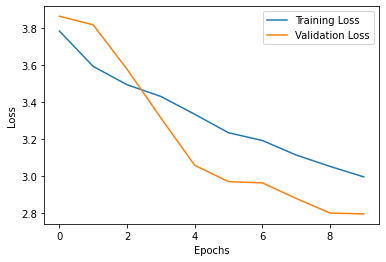

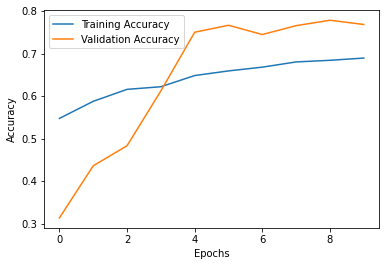

In [21]:
# Plot training history
plt.plot(new_history.history['loss'], label='Training Loss')
plt.plot(new_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(new_history.history['accuracy'], label='Training Accuracy')
plt.plot(new_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
new_test_metrics = new_model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Metrics:", new_test_metrics)

41/41 [==============================] - 19s 455ms/step - loss: 3.0492 - accuracy: 0.7354
Test Metrics: [3.0492358207702637, 0.7353630065917969]


41/41 [==============================] - 18s 432ms/step


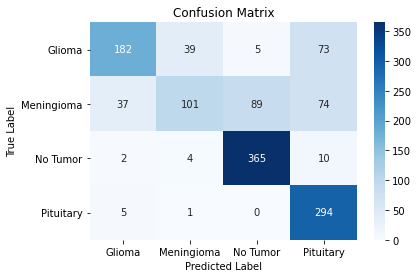

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.61      0.69       299
           1       0.70      0.34      0.45       301
           2       0.80      0.96      0.87       381
           3       0.65      0.98      0.78       300

    accuracy                           0.74      1281
   macro avg       0.74      0.72      0.70      1281
weighted avg       0.74      0.74      0.71      1281



In [23]:
# Get true labels
true_labels = []
for i in range(test_steps_per_epoch):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Get predicted labels
new_predicted_labels = new_model.predict(test_generator, steps=test_steps_per_epoch)
new_predicted_labels = np.argmax(new_predicted_labels, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, new_predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma','Meningioma','No Tumor','Pituitary'], yticklabels=['Glioma','Meningioma','No Tumor','Pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, new_predicted_labels))

### HyperParameter Tunning

In [24]:
def build_classifier(optimizer, num_layers, dropout_rate, dense_neurons):
    classifier = Sequential()

    # Convolutional layers
    for _ in range(num_layers):
        classifier.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
        classifier.add(MaxPooling2D((2, 2)))
        classifier.add(BatchNormalization())
        classifier.add(Dropout(dropout_rate))

    classifier.add(Flatten())
    classifier.add(Dense(dense_neurons, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    classifier.add(BatchNormalization()) 
    classifier.add(Dropout(0.4))
    classifier.add(Dense(4, activation='softmax'))

    classifier.compile(optimizer=optimizer,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
    
    return classifier


In [25]:
# Create the KerasClassifier
keras_classifier = KerasClassifier(build_fn=build_classifier, dense_neurons =[64, 128, 256], dropout_rate = [0.2, 0.3, 0.4], num_layers = [1,2,3])

In [29]:
param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'num_layers': [1, 2, 3],
    'dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [25, 32],
    'epochs': [10]
}

In [27]:
# Create an instance of the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Wrap the EarlyStopping callback in a list
callbacks = [[early_stopping]]

grid = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=3, scoring='accuracy')


In [30]:
# Perform grid search
grid_result = grid.fit(train_generator, steps_per_epoch=train_steps_per_epoch,
                       validation_data=val_generator, validation_steps=val_steps_per_epoch,
                       callbacks=callbacks)

# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

KeyboardInterrupt: 

### Pre-trained Models

#### XCeption

In [31]:
base_model1 = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model1.layers:
    layer.trainable = False

pre_trained1_model = Sequential()
pre_trained1_model.add(base_model1)
pre_trained1_model.add(layers.Flatten())
pre_trained1_model.add(layers.Dropout(0.5))
pre_trained1_model.add(layers.Dense(128, activation='relu'))
pre_trained1_model.add(layers.Dropout(0.5))
pre_trained1_model.add(layers.Dense(4, activation='softmax'))
pre_trained1_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

pre_trained1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_2 (Dropout)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               12845184  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 33707180 (128.58 MB)
Trainable params: 1

In [32]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the new model with early stopping
pretrained1_history = pre_trained1_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping])

Epoch 1/10
138/138 [==============================] - 698s 5s/step - loss: 1.3981 - accuracy: 0.6267 - val_loss: 0.5219 - val_accuracy: 0.8002
Epoch 2/10
138/138 [==============================] - 735s 5s/step - loss: 0.7186 - accuracy: 0.7168 - val_loss: 0.4584 - val_accuracy: 0.8238
Epoch 3/10
138/138 [==============================] - 735s 5s/step - loss: 0.6676 - accuracy: 0.7448 - val_loss: 0.4552 - val_accuracy: 0.8229
Epoch 4/10
138/138 [==============================] - 737s 5s/step - loss: 0.6569 - accuracy: 0.7421 - val_loss: 0.4123 - val_accuracy: 0.8438
Epoch 5/10
138/138 [==============================] - 738s 5s/step - loss: 0.6504 - accuracy: 0.7366 - val_loss: 0.3985 - val_accuracy: 0.8683
Epoch 6/10
138/138 [==============================] - 738s 5s/step - loss: 0.6094 - accuracy: 0.7570 - val_loss: 0.3683 - val_accuracy: 0.8701
Epoch 7/10
138/138 [==============================] - 742s 5s/step - loss: 0.5729 - accuracy: 0.7723 - val_loss: 0.3377 - val_accuracy: 0.8783

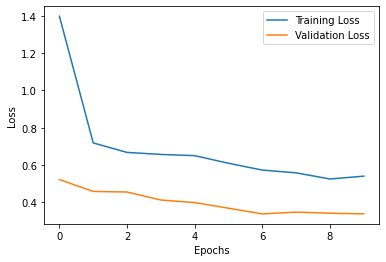

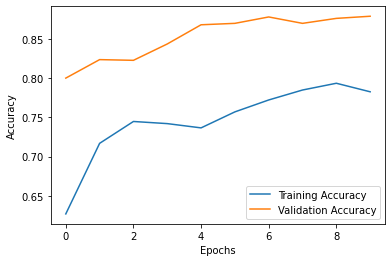

In [33]:
# Plot training history
plt.plot(pretrained1_history.history['loss'], label='Training Loss')
plt.plot(pretrained1_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(pretrained1_history.history['accuracy'], label='Training Accuracy')
plt.plot(pretrained1_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
pretrained1_test_metrics = pre_trained1_model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Metrics:", pretrained1_test_metrics)

41/41 [==============================] - 157s 4s/step - loss: 0.3637 - accuracy: 0.8728
Test Metrics: [0.36371445655822754, 0.8727556467056274]


41/41 [==============================] - 155s 4s/step


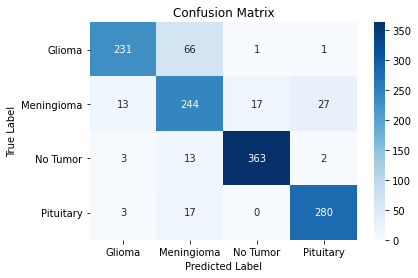

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       299
           1       0.72      0.81      0.76       301
           2       0.95      0.95      0.95       381
           3       0.90      0.93      0.92       300

    accuracy                           0.87      1281
   macro avg       0.87      0.87      0.87      1281
weighted avg       0.88      0.87      0.87      1281



In [35]:
# Get true labels
true_labels = []
for i in range(test_steps_per_epoch):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Get predicted labels
pretrained1_predicted_labels = pre_trained1_model.predict(test_generator, steps=test_steps_per_epoch)
pretrained1_predicted_labels = np.argmax(pretrained1_predicted_labels, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, pretrained1_predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma','Meningioma','No Tumor','Pituitary'], yticklabels=['Glioma','Meningioma','No Tumor','Pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, pretrained1_predicted_labels))

#### VGG16

In [36]:
base_model2 = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze all layers in the base model
for layer in base_model2.layers:
    layer.trainable = False

# Unfreeze specific layers in the base model
base_model2.layers[-2].trainable = True
base_model2.layers[-3].trainable = True
base_model2.layers[-4].trainable = True

# Create a Sequential model
pre_trained2_model = Sequential()
pre_trained2_model.add(layers.Input(shape=(224, 224, 3)))
pre_trained2_model.add(base_model2)
pre_trained2_model.add(layers.Flatten())
pre_trained2_model.add(layers.Dropout(0.3))
pre_trained2_model.add(layers.Dense(128, activation='relu'))
pre_trained2_model.add(layers.Dropout(0.2))
pre_trained2_model.add(layers.Dense(4, activation='softmax'))

# Compile the model
pre_trained2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
pre_trained2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_4 (Dropout)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17926596 (68.38 MB)
Trainable params: 10

In [37]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the new model with early stopping
pretrained2_history = pre_trained2_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping])

Epoch 1/10
138/138 [==============================] - 1976s 14s/step - loss: 1.4320 - accuracy: 0.2536 - val_loss: 1.3862 - val_accuracy: 0.2625
Epoch 2/10
138/138 [==============================] - 1973s 14s/step - loss: 1.3860 - accuracy: 0.2557 - val_loss: 1.3860 - val_accuracy: 0.2625
Epoch 3/10
138/138 [==============================] - 1979s 14s/step - loss: 1.3858 - accuracy: 0.2625 - val_loss: 1.3860 - val_accuracy: 0.2625
Epoch 4/10
138/138 [==============================] - 1979s 14s/step - loss: 1.3857 - accuracy: 0.2625 - val_loss: 1.3860 - val_accuracy: 0.2625
Epoch 5/10
138/138 [==============================] - 1985s 14s/step - loss: 1.3856 - accuracy: 0.2625 - val_loss: 1.3861 - val_accuracy: 0.2625


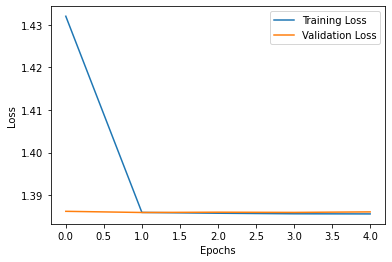

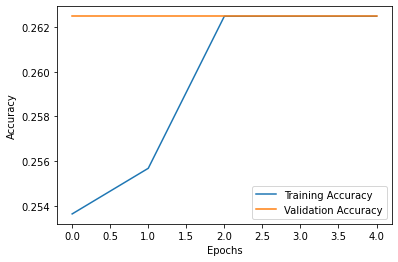

In [38]:
# Plot training history
plt.plot(pretrained2_history.history['loss'], label='Training Loss')
plt.plot(pretrained2_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(pretrained2_history.history['accuracy'], label='Training Accuracy')
plt.plot(pretrained2_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
pretrained2_test_metrics = pre_trained2_model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Metrics:", pretrained2_test_metrics)

41/41 [==============================] - 388s 9s/step - loss: 1.3857 - accuracy: 0.2342
Test Metrics: [1.3856841325759888, 0.23419204354286194]


41/41 [==============================] - 388s 9s/step


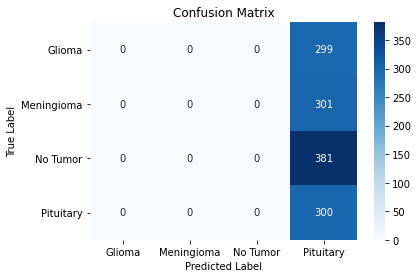

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       299
           1       0.00      0.00      0.00       301
           2       0.00      0.00      0.00       381
           3       0.23      1.00      0.38       300

    accuracy                           0.23      1281
   macro avg       0.06      0.25      0.09      1281
weighted avg       0.05      0.23      0.09      1281



C:\Users\andmpereira\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andmpereira\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andmpereira\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [40]:
# Get true labels
true_labels = []
for i in range(test_steps_per_epoch):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Get predicted labels
pretrained2_predicted_labels = pre_trained2_model.predict(test_generator, steps=test_steps_per_epoch)
pretrained2_predicted_labels = np.argmax(pretrained2_predicted_labels, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, pretrained2_predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma','Meningioma','No Tumor','Pituitary'], yticklabels=['Glioma','Meningioma','No Tumor','Pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, pretrained2_predicted_labels))